In [1]:
import pickle 
import numpy as np 
import pandas as pd
import networkx as nx
from tqdm import tqdm
import time
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import community
import collections
import seaborn.objects as so
from scipy.stats import chi2_contingency

from src.utils.data_utils import *
from src.utils.general_utils import *
from src.utils.mapping import *
from src.utils.langue import *

In [4]:
movie_path = 'data/Movie.pkl'
actors_path = 'data/Actor.pkl'

with open(movie_path, 'rb') as file:
    Movie = pickle.load(file)
Movie = Movie.reset_index()
with open(actors_path, 'rb') as file:
    Actor = pickle.load(file)

C:\Users\Thibault Schiesser\AppData\Local\Temp\ipykernel_26768\2668311966.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  Movie = pickle.load(file)


In [8]:
a = create_actor_language_dataset(Movie, Actor, 5)

We lose 11.47% of the dataset of movies with this operation.


In [9]:
presence = create_cross_language(a)
compte = create_cross_language_count(a)

regardons si nous avons la même proportion de language de langue pour chaque nb_movie <br> on considère 4 groupes :
- 1 <= nb_film <= 5
- 5 < nb_film <= 10
- 11 < nb_movie <= 50
- nb_movie > 25
 
<br> h0 : la proportion des langues est la même dans chaque groupe

In [10]:
a["nb_movie"]= a.sum(axis=1)

In [11]:
dict_group = {}
group1 = a[a["nb_movie"]<=5]
dict_group[1] = group1
group2 = a[(a["nb_movie"]>5) & (a["nb_movie"]<11)]
dict_group[2] = group2
group3 = a[(a["nb_movie"]<26) & (a["nb_movie"]>10)]
dict_group[3] = group3
group4 = a[a["nb_movie"]>25]
dict_group[4] = group4
print(group1.shape[0] + group2.shape[0] + group3.shape[0] + group4.shape[0] == a.shape[0])

True


In [12]:
print(group1.shape[0])
print(group2.shape[0])
print(group3.shape[0])
print(group4.shape[0])

79474
5678
4354
1849


In [13]:
nb_group = 4
dict_total = {}

for g in range(1, nb_group + 1):
    group = dict_group[g]
    total_movie = group.nb_movie.sum()
    
    for i in group.columns:
        if i != "nb_movie":
            ratio = float(group[i].sum())
    
            if i in dict_total:
                dict_total[i].append(ratio)
            else:
                dict_total[i] = [ratio]

print(dict_total)

{'English Language': [95254.0, 32840.0, 54344.0, 56352.0], 'Hindi Language': [4176.0, 2387.0, 5441.0, 12806.0], 'Spanish Language': [8795.0, 2180.0, 2720.0, 2775.0], 'French Language': [11614.0, 3379.0, 4322.0, 4061.0], 'Italian Language': [6469.0, 2039.0, 2614.0, 2607.0]}


In [15]:
df = pd.DataFrame(dict_total, index=[1,2,3,4])

In [16]:
df = df.T

In [17]:
df

,1,2,3,4
English Language,95254.0,32840.0,54344.0,56352.0
Hindi Language,4176.0,2387.0,5441.0,12806.0
Spanish Language,8795.0,2180.0,2720.0,2775.0
French Language,11614.0,3379.0,4322.0,4061.0
Italian Language,6469.0,2039.0,2614.0,2607.0


In [18]:
chi2, p_value, dof, expected = chi2_contingency(df)

In [19]:
# Résultats
print("Statistique du Chi-2 :", chi2)
print("P-value :", p_value)
print("Degrés de liberté :", dof)
print("Tableau attendu théorique :\n", expected)

# Conclusion
if p_value < 0.05:
    print("Les distributions sont statistiquement différentes (p < 0.05).")
else:
    print("Aucune différence significative entre les distributions (p >= 0.05).")

Statistique du Chi-2 : 14072.996909615065
P-value : 0.0
Degrés de liberté : 12
Tableau attendu théorique :
 [[95092.8897927  32241.44951525 52279.70801608 59175.95267597]
 [ 9880.03934736  3349.84866399  5431.80014188  6148.31184677]
 [ 6558.81693072  2223.78103571  3605.87458028  4081.5274533 ]
 [ 9308.98024119  3156.22984157  5117.84603452  5792.94388271]
 [ 5467.27368803  1853.69094349  3005.77122724  3402.26414125]]
Les distributions sont statistiquement différentes (p < 0.05).


balance dataset ???

plot :

In [20]:
expected = expected.T

In [21]:
expected[0]

array([95092.8897927 ,  9880.03934736,  6558.81693072,  9308.98024119,
        5467.27368803])

In [22]:
df = df.T

In [23]:
df.iloc[0,:].values/np.sum(df.iloc[0,:].values)

array([0.75414067, 0.03306204, 0.06963138, 0.09194984, 0.05121607])

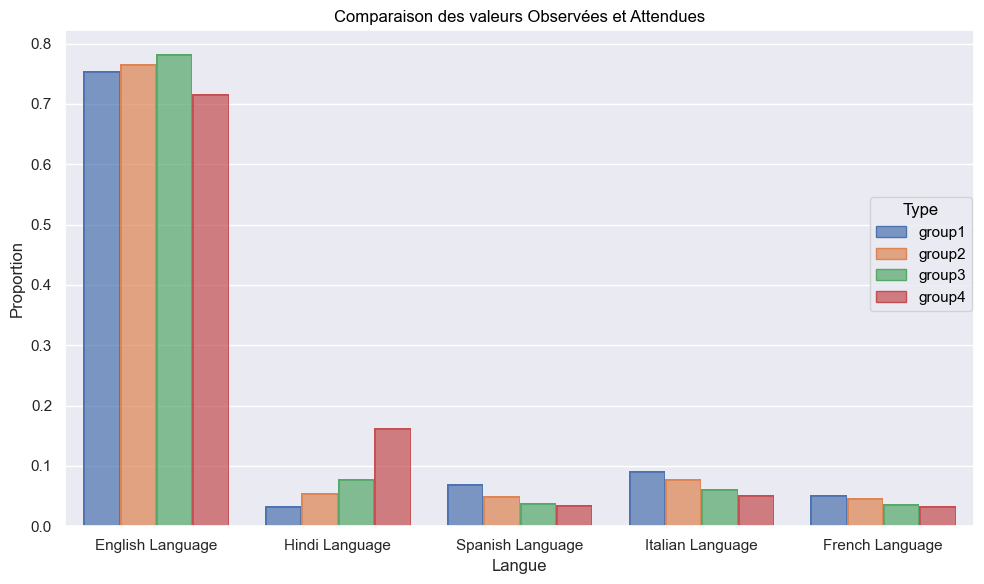

In [24]:
languages = ['English Language', 'Hindi Language', 'Spanish Language', 'Italian Language', 'French Language']
g1 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[0,:].values/np.sum(df.iloc[0,:].values),
    'Type': 'group1'
})
g2 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[1,:].values/np.sum(df.iloc[1,:].values),
    'Type': 'group2'
})
g3 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[2,:].values/np.sum(df.iloc[2,:].values),
    'Type': 'group3'
})
g4 = pd.DataFrame({
    'Language': languages,
    'Value': df.iloc[3,:].values/np.sum(df.iloc[3,:].values),
    'Type': 'group4'
})
combined_df = pd.concat([g1,g2,g3,g4])
p = (
    so.Plot(combined_df, x="Language", y="Value", color="Type")  # Type pour la couleur
    .add(so.Bar(), so.Dodge())  # Barres avec un décalage pour les deux types
    .layout(size=(10, 6))  # Taille du graphique
    .label(title="Comparaison des valeurs Observées et Attendues", 
           x="Langue", 
           y="Proportion")
)

p.show()

In [25]:
Actor.head()

,Freebase_actor_ID,actor_name,actor_DOB,actor_gender,actor_height,ethnicity,Freebase_movie_ID,actor_age_atmovierelease
0,/m/010p3,Adam Carolla,1964-05-27,M,1.88,Italian Americans,"[/m/0bq2wj, /m/08hjr9, /m/06zm9p7, /m/06c5z_, ...","[35.0, 35.0, 45.0, 33.0, 33.0, 34.0, 42.0, 35...."
1,/m/010q36,Fred Rogers,1928-03-20,M,NaN,None,[/m/033pf1],[67.0]
2,/m/010wx,Aria Giovanni,1977-11-03,F,1.68,Yugoslavs,[/m/07gx0c],[25.0]
3,/m/010xjr,Richard Harris,1930-10-01,M,1.85,Irish people,"[/m/0c_6bf, /m/078mm1, /m/03qfyt, /m/0cz7_4w, ...","[66.0, 46.0, <NA>, 59.0, 48.0, 39.0, 66.0, 50...."
4,/m/0112yl,Toshiro Mifune,1920-04-01,M,1.74,None,"[/m/0513nd, /m/05c2g3q, /m/04wjg1, /m/01tch8, ...","[31.0, 42.0, 45.0, 41.0, 62.0, 29.0, 30.0, 38...."


In [26]:
abc = get_most_represented_language(Movie, 8)

In [27]:
abc

Index(['English Language', 'Hindi Language', 'Spanish Language',
       'French Language', 'Italian Language', 'German Language', 'Silent film',
       'Japanese Language'],
      dtype='object', name='Movie_languages')

In [28]:
start_time = time.time()
G = custom_create_actor_network(Actor, Movie, min_movies=60, min_releasedate=3000)
print("Created graph with actors:")
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
end_time = time.time()
print(f"time to compute: {end_time - start_time:.1f} seconds")
partition = community.best_partition(G)
values = [partition.get(node) for node in G.nodes()]
counter=collections.Counter(values)

Creating network: 100%|██████████| 21733/21733 [00:57<00:00, 378.16it/s] 


Created graph with actors:
Number of nodes: 422
Number of edges: 9471
time to compute: 58.4 seconds


In [29]:
list_edge_with_attributes = [(e[0], e[1], G[e[0]][e[1]]['langue']) for e in G.edges]

In [44]:
langue_color_mapping = {
    'English Language': "#cfe2f3",  # Light blue
    'French Language': "#f8d7da",   # Light pink
    'Hindi Language': "#d4edda",    # Light green
    'Spanish Language': "#fff3cd",  # Light yellow
    'Italian Language': "#e2c2f7",  # Light purple
    'German Language': "#d1ecf1",   # Light cyan
    'Silent film': "#f9c9a0",       # Light peach
    'Japanese Language': "#f1e8e2", # Light beige
}

In [45]:
default_color = (0, 0, 0, 0)
edge_colors = [
    langue_color_mapping.get(G[u][v]["langue"], default_color) for u, v in G.edges
]


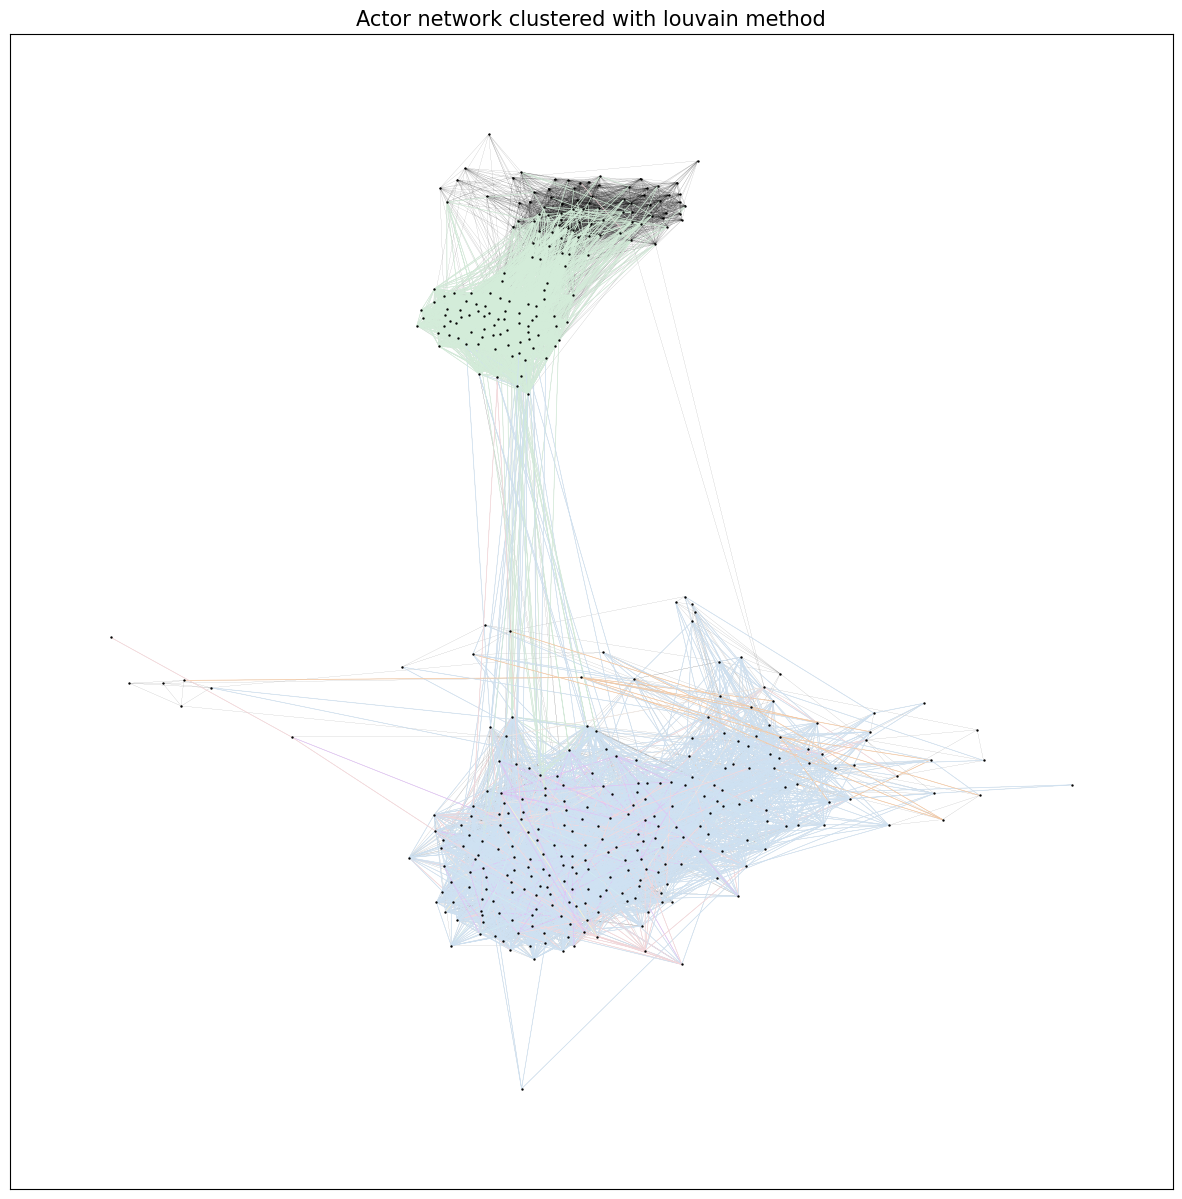

time to compute: 1.6 seconds


In [46]:
start_time = time.time()
sp = nx.spring_layout(G, k=0.2, seed=42)
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos=sp, with_labels=False, node_size=0.5, node_color="k", width=0.05)
nx.draw_networkx_edges(G, pos=sp, width=0.5, edge_color=edge_colors, style='solid')
# plt.axes('off')
plt.title("Actor network clustered with louvain method", fontsize=15)
plt.show()
end_time = time.time()
print(f"time to compute: {end_time - start_time:.1f} seconds")